In [32]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data')

# Standardize data
df2 = df.copy()
df2["famhist"] = 1 * (df2["famhist"] == "Present")
cols = ["sbp", "tobacco", "ldl", "adiposity", "typea", "obesity", "alcohol", "age"]
df2[cols] = (df2[cols] - df2[cols].mean(0)) / df2[cols].std(0)
df2 = df2.drop("row.names", axis=1)


# Data
X = df2[cols].values
y = df2.values[:,-1]


y_regr = df2["typea"].values.squeeze()
X_regr = df2.drop(columns="typea").values.squeeze()

print(np.sum((y==1)*1))


160


In [33]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
## OPGAVE 5 ##
opt_lambda = 100
# Training logistic regression model with optimal lambda
mdl = LogisticRegression(penalty='l2', C=opt_lambda)    
mdl.fit(X, y)
w_est = mdl.coef_[0]
predicted_classes = mdl.predict(X)
accuracy = accuracy_score(y.flatten(),predicted_classes)

print(accuracy)
print(w_est)

0.7229437229437229
[ 0.1156255   0.33397725  0.39857191  0.13280393  0.39719699 -0.24403499
  0.03538422  0.73977962]


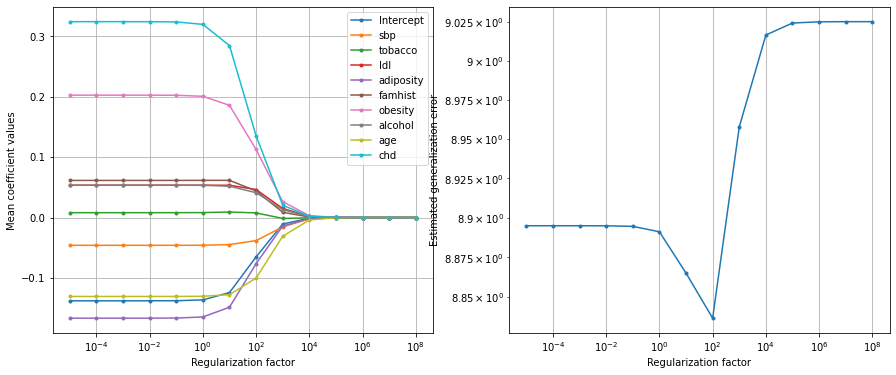

Best mean weights
[-0.06516819 -0.03815269  0.00763306  0.04637283 -0.07625191  0.04406509
  0.11261008  0.04113044 -0.10016369  0.13516465]
Best weights
[-0.06011771 -0.05258423  0.01553294  0.04831579 -0.09326865  0.04741779
  0.1399882   0.03412814 -0.11362192  0.13609777]
8.836700115243186


In [34]:

import numpy as np
import sklearn.linear_model as lm
from sklearn import model_selection
import matplotlib.pyplot as plt


K1 = 10
lambdas = np.power(10., range(-5, 9))

K1fold = model_selection.KFold(n_splits=K1, shuffle = True)

errors = np.zeros((K1, len(lambdas)))
weights = np.zeros((K1, len(lambdas), X_regr.shape[1] + 1))

for i, (train_index, test_index) in enumerate(K1fold.split(X, y)):
  X_regr_train = X_regr[train_index]
  y_regr_train = y_regr[train_index]

  X_regr_test = X_regr[test_index]
  y_regr_test = y_regr[test_index]

  
  for j, l in enumerate(lambdas):
    model = lm.Ridge(alpha=l)
    model.fit(X_regr_train, y_regr_train)
    y_hat = model.predict(X_regr_test)
    error = ((y_regr_test - y_hat) ** 2).mean()
    errors[i, j] = (X_regr_train.shape[0] / X_regr.shape[0]) * error
    weights[i, j, 0] = model.intercept_
    weights[i, j, 1:] = model.coef_


gen_errors = errors.sum(0)
best_gen_error_index = np.argmin(gen_errors)
best_lambda = lambdas[best_gen_error_index]
mean_weights = weights.mean(0)
best_mean_weights = mean_weights[best_gen_error_index]
best_fold = np.argmin(errors[:, best_gen_error_index])
best_weights = weights[best_fold, best_gen_error_index]


plt.figure(2, figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.grid()
plt.semilogx(lambdas, mean_weights, ".-")
plt.xlabel('Regularization factor')
plt.ylabel('Mean coefficient values')
plt.legend(["Intercept", "sbp", "tobacco", "ldl", "adiposity",	"famhist", "obesity", "alcohol", "age", "chd"])


plt.subplot(1, 2, 2)
plt.loglog(lambdas, gen_errors, ".-")
plt.xlabel('Regularization factor')
plt.ylabel('Estimated generalization error')
plt.grid()
plt.show()


# pd.DataFrame(data=np.array([lambdas, gen_errors]).T, columns=["Lambda", "Gen. error"])


print("Best mean weights")
print(best_mean_weights)

print("Best weights")
print(best_weights)
print(np.min(gen_errors))

In [35]:
import math
import numpy as np
import torch
import torch.nn as nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as st 




# Create two Layer Cross Validation function
def twoLayerCrossValidation(model_types, parameter_types, X, y, error_fn, K1 = 10, K2 = 10):
  test_errors = np.zeros((K1,len(model_types)*2))
#  best_parameters = np.zeros((K1,len(model_types)))
  y_hat_list = []
  y_test_list = []
  for i in range(len(model_types)):
    y_hat_list.append([])

  # The two layer cross-validation algorithm
  K1fold = model_selection.KFold(n_splits=K1, shuffle = True)
  for i, (par_index, test_index) in enumerate(K1fold.split(X, y)):
    print("Outer fold {} of {}".format(i+1,K1))

    K2fold = model_selection.KFold(n_splits=K2, shuffle = True)

    # Saves D_par and D_test to allow later statistical evaluation
    X_par = X[par_index, :]
    y_par = y[par_index]

    X_test = X[test_index, :]
    y_test = y[test_index]
    y_test_list.append(y_test)
    for m, (model_type, models) in enumerate(model_types): # Iterate over the three methods chosen for classification    
      val_errors = np.zeros((K2, len(models)))

      # Inner cross validation loop
      for j, (train_index, val_index) in enumerate(K2fold.split(X_par, y_par)):
        X_train = X_par[train_index, :]
        y_train = y_par[train_index]

        X_val = X_par[val_index, :]
        y_val = y_par[val_index]

        # Test modeltype and calculate validation error for each model of the three methods
        for k, (name, parameter, model) in enumerate(models):
          model.fit(X_train, y_train)

          y_hat = model.predict(X_val)
          val_errors[j, k] = len(X_val) / len(X_par) * error_fn(y_hat, y_val)

      # Finds the optimal model
      inner_gen_errors = val_errors.sum(axis=0)
      best_model_index = np.argmin(inner_gen_errors)
      best_model_name, best_model_parameter, best_model = models[best_model_index] # Determines optimal model
      if name == 'Base Line':
        model.fit(X_par,y_par)
        y_hat = np.ones(len(y_test)) * model.predict(X_test)
        

      else:

        best_model.fit(X_par, y_par)
        y_hat = best_model.predict(X_test)
      y_hat_list[m].append(y_hat.squeeze())
      
      test_errors[i,m*2+1] = error_fn(y_hat, y_test)  # Lists test_erros for each method and each outer fold
      test_errors[i,m*2] = best_model_parameter # List the best parametertype belonging to test-error


  test_errors_folds = pd.DataFrame.from_records(data = test_errors, 
                                                columns=sum([[parameter_types[i],model_types[i][0]] for i in range(len(model_types))],[]))

  return test_errors_folds, y_hat_list, y_test_list

"""
Baseline for classification and regression
"""
# Baseline for classification
class BaseLine_Classification:
  def fit(self, X, y):
    self.bincount = np.bincount(y.astype(int)).argmax()
  
  def predict(self, X):
    return self.bincount

# Baseline for regression
class BaseLine:
  def fit(self, X, y):
    self.mean = y.mean()
  
  def predict(self, X):
    return self.mean

"""
Python class ANN for regression and CV
"""

class ANN:
  def __init__(
    self,
    hidden_units, 
    criterion = nn.MSELoss(),
    tolerance = 1e-6,
    optimizer = lambda params: torch.optim.SGD(params, lr = 1e-2),
    
  ):
    self.criterion = criterion
    self.optimizer = optimizer
    self.max_iter = 1000
    self.tolerance = tolerance
    self.hidden_units = hidden_units

  def fit(self, X, y):
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape((-1, 1))

    self.model = nn.Sequential(
      #nn.Linear(X.shape[1], y.shape[1])
      nn.Linear(X.shape[1], self.hidden_units),
      nn.Tanh(),
      nn.Linear(self.hidden_units, y.shape[1])
    )

    print("Starting training.")
    optimizer = self.optimizer(self.model.parameters())
    old_loss = math.inf
    loss_history = []
    for i in range(self.max_iter):
      optimizer.zero_grad()

      y_hat = self.model(X)
      loss = self.criterion(y_hat, y)
      loss.backward()
      loss_value = loss.item()
      loss_history.append(loss_value)

      p_delta_loss = np.abs(loss_value - old_loss) / old_loss
      if p_delta_loss < self.tolerance: break
      old_loss = loss_value
      
      optimizer.step()
    print("Training done.")
    plt.plot(loss_history)
    plt.show()
    
  def predict(self, X):
    X = torch.Tensor(X)
    y = self.model.forward(X)
    return y.detach().numpy()

def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    # perform McNemars test
    nn = np.zeros((2,2))
    c1 = yhatA - y_true == 0
    c2 = yhatB - y_true == 0

    nn[0,0] = sum(c1 & c2)
    nn[0,1] = sum(c1 & ~c2)
    nn[1,0] = sum(~c1 & c2)
    nn[1,1] = sum(~c1 & ~c2)

    n = sum(nn.flat);
    n12 = nn[0,1]
    n21 = nn[1,0]

    thetahat = (n12-n21)/n
    Etheta = thetahat

    Q = n**2 * (n+1) * (Etheta+1) * (1-Etheta) / ( (n*(n12+n21) - (n12-n21)**2) )

    p = (Etheta + 1) * (Q-1)
    q = (1-Etheta) * (Q-1)

    CI = tuple(lm * 2 - 1 for lm in st.beta.interval(1-alpha, a=p, b=q) )

    p = 2*st.binom.cdf(min([n12,n21]), n=n12+n21, p=0.5)
    # print("Result of McNemars test using alpha=", alpha)
    # print("Comparison matrix n")
    # print(nn)
    if n12+n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=",(n12+n21))

    # print("Approximate {} confidence interval of theta: [thetaL,thetaU] = ".format(1-alpha), CI)
    # print("p-value for two-sided test A and B have same accuracy (exact binomial test): p=", p)

    # thetahat = 2*thetahat-1
    return thetahat, CI, p

Outer fold 1 of 10
Starting training.


C:\Users\ZHU Zheng\AppData\Local\Temp\ipykernel_22600\1666663640.py:141: RuntimeWarning: invalid value encountered in double_scalars
  p_delta_loss = np.abs(loss_value - old_loss) / old_loss


Training done.


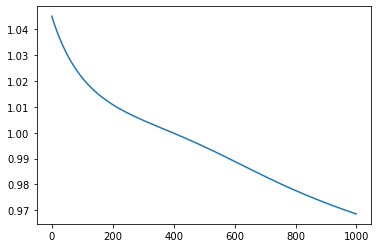

Starting training.
Training done.


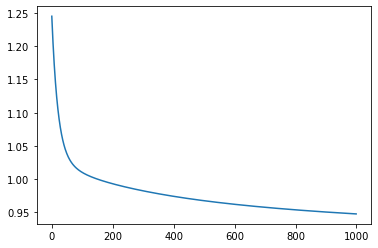

Starting training.
Training done.


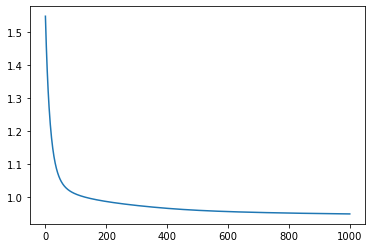

Starting training.
Training done.


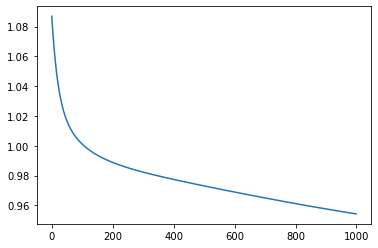

Starting training.
Training done.


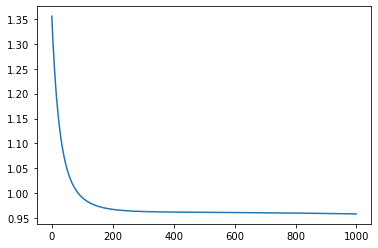

Starting training.
Training done.


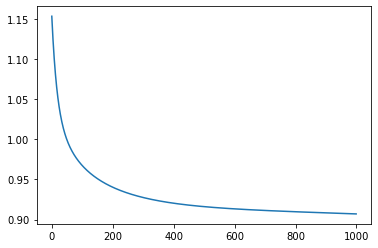

Starting training.
Training done.


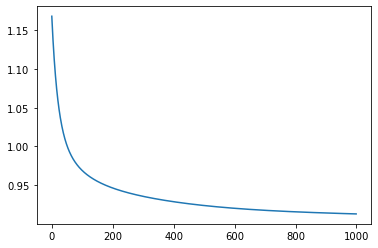

Starting training.
Training done.


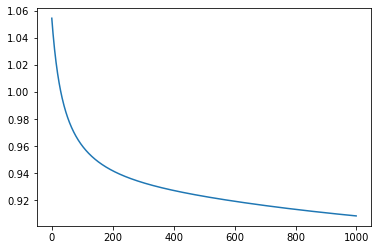

Starting training.
Training done.


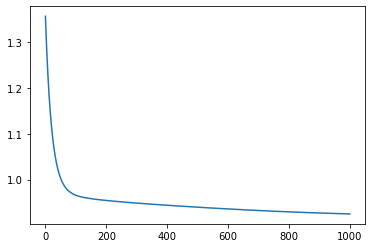

Starting training.
Training done.


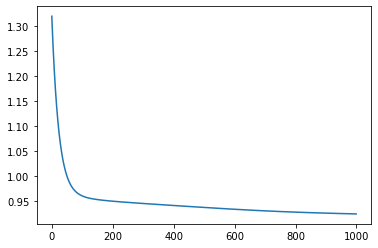

Starting training.
Training done.


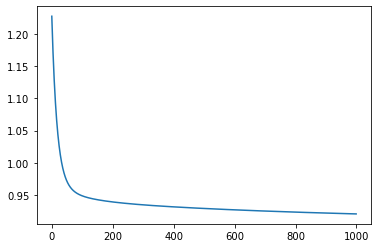

Starting training.
Training done.


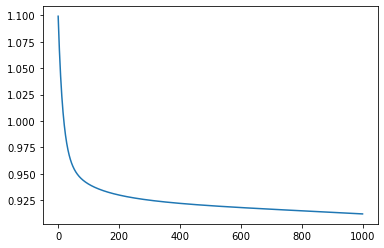

Starting training.
Training done.


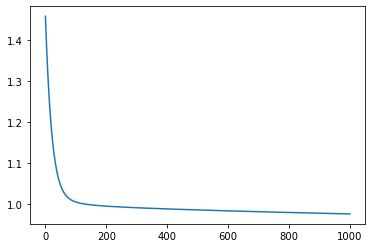

Starting training.
Training done.


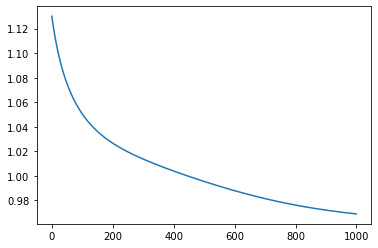

Starting training.
Training done.


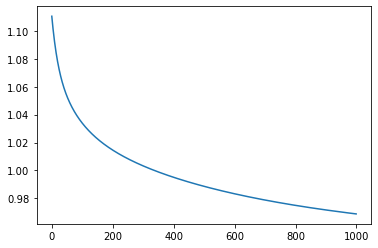

Starting training.
Training done.


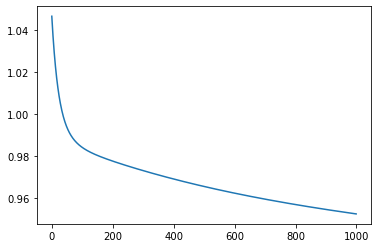

Starting training.
Training done.


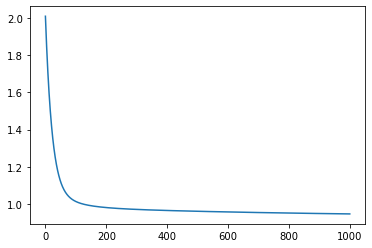

Starting training.
Training done.


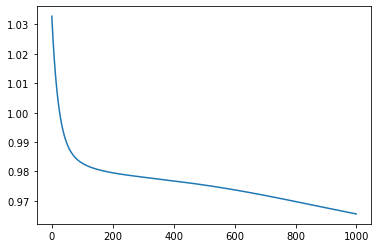

Starting training.
Training done.


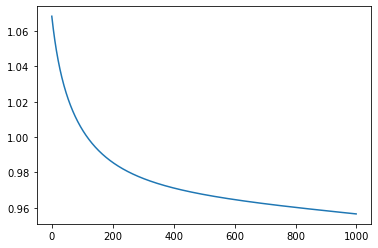

Starting training.
Training done.


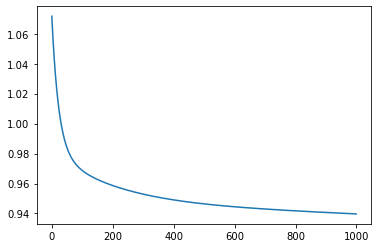

Starting training.
Training done.


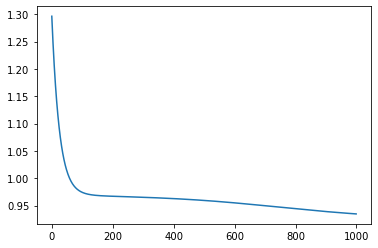

Starting training.
Training done.


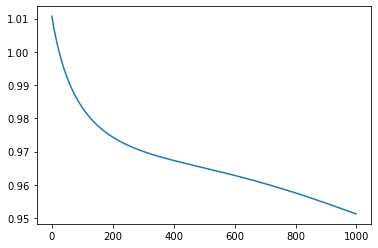

Starting training.
Training done.


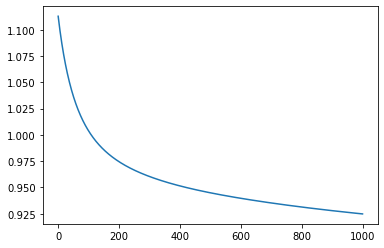

Starting training.
Training done.


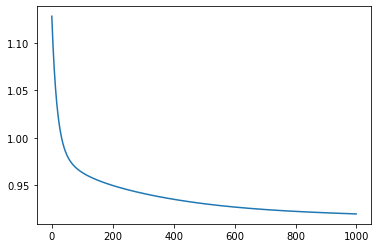

Starting training.
Training done.


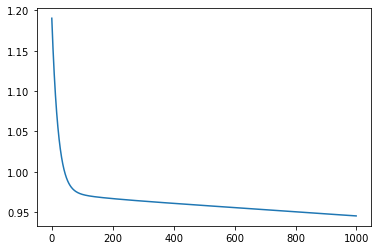

Starting training.
Training done.


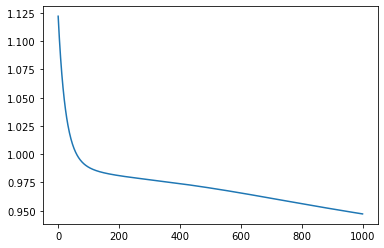

Starting training.
Training done.


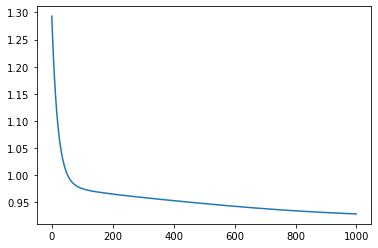

Starting training.
Training done.


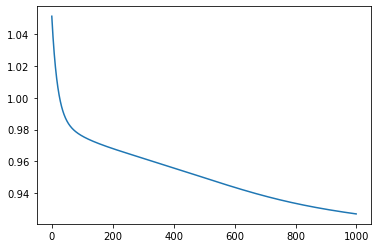

Starting training.
Training done.


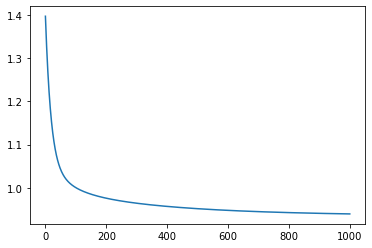

Starting training.
Training done.


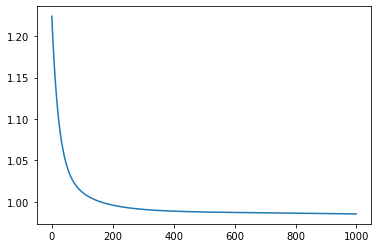

Starting training.
Training done.


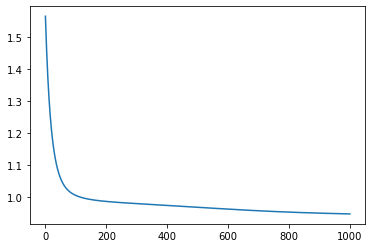

Starting training.
Training done.


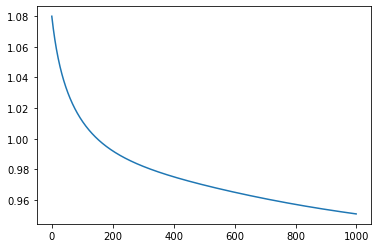

Starting training.
Training done.


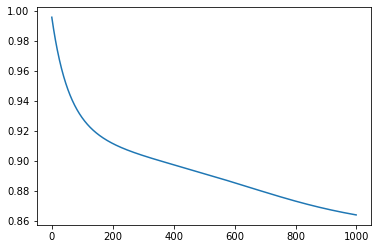

Starting training.
Training done.


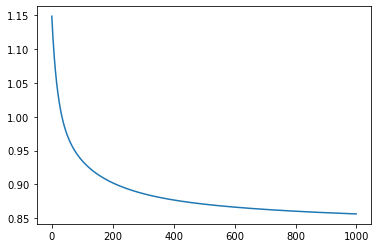

Starting training.
Training done.


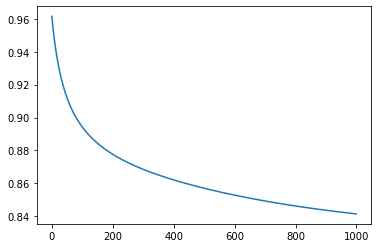

Starting training.
Training done.


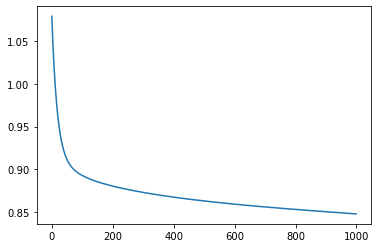

Starting training.
Training done.


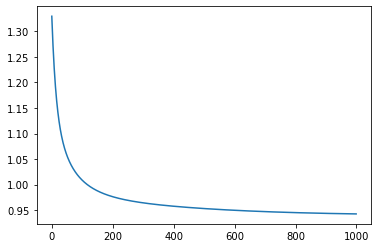

Starting training.
Training done.


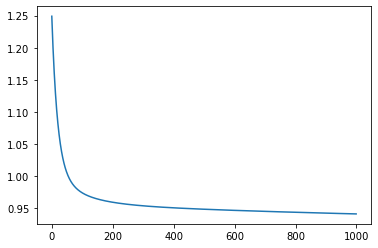

Starting training.
Training done.


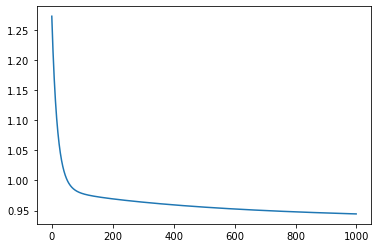

Starting training.
Training done.


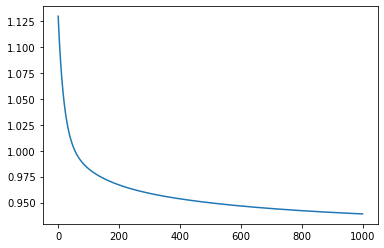

Starting training.
Training done.


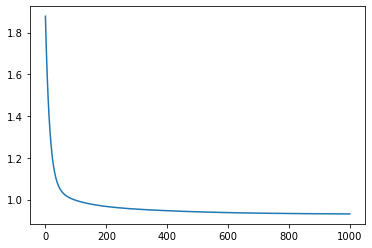

Outer fold 2 of 10
Starting training.


C:\Users\ZHU Zheng\AppData\Local\Temp\ipykernel_22600\1666663640.py:141: RuntimeWarning: invalid value encountered in double_scalars
  p_delta_loss = np.abs(loss_value - old_loss) / old_loss


Training done.


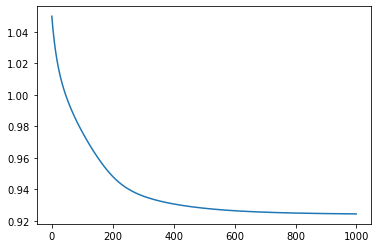

Starting training.
Training done.


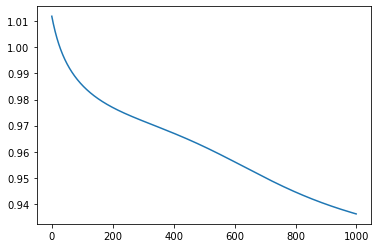

Starting training.
Training done.


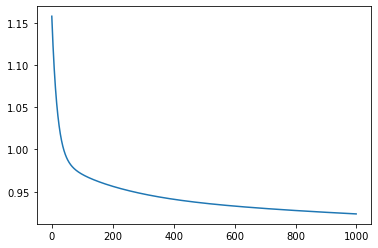

Starting training.
Training done.


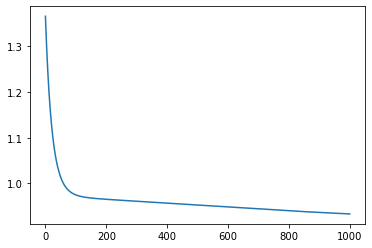

Starting training.
Training done.


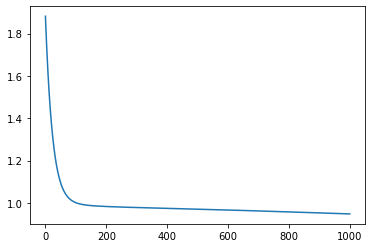

Starting training.
Training done.


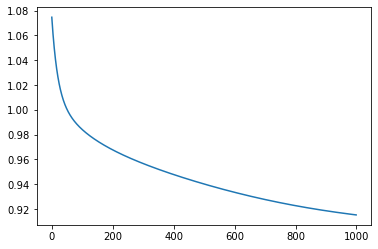

Starting training.
Training done.


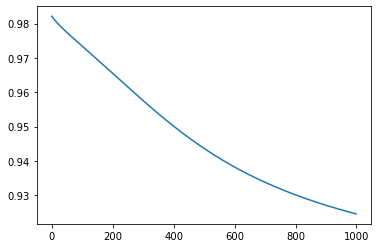

Starting training.
Training done.


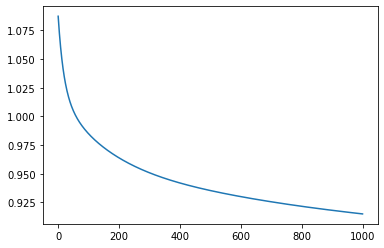

Starting training.
Training done.


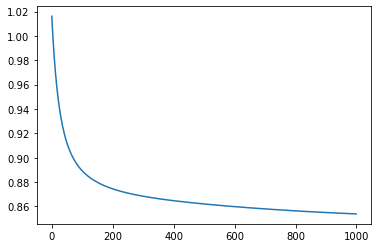

Starting training.
Training done.


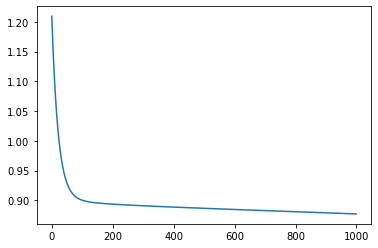

Starting training.
Training done.


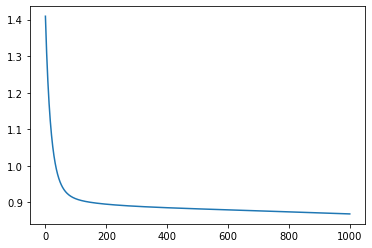

Starting training.
Training done.


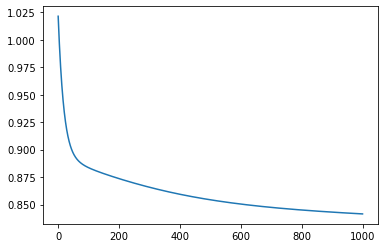

Starting training.
Training done.


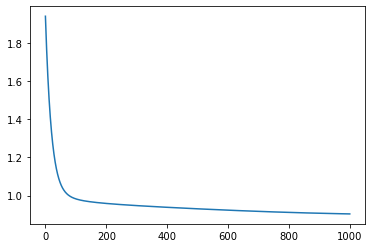

Starting training.
Training done.


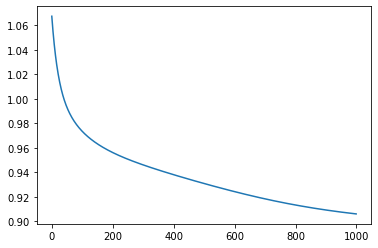

Starting training.
Training done.


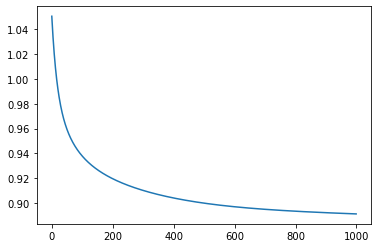

Starting training.
Training done.


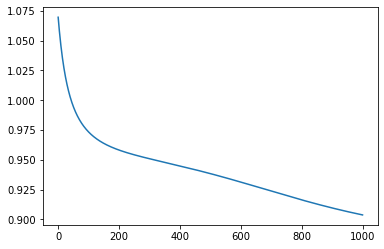

Starting training.
Training done.


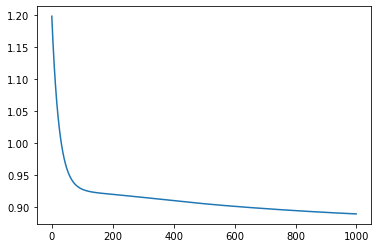

Starting training.
Training done.


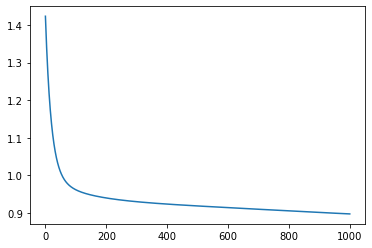

Starting training.
Training done.


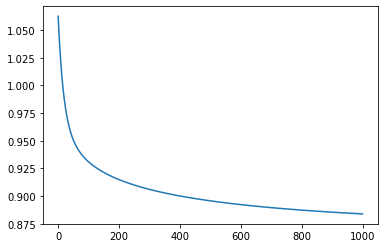

Starting training.
Training done.


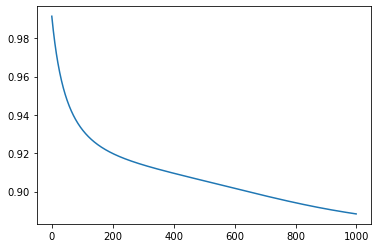

Starting training.
Training done.


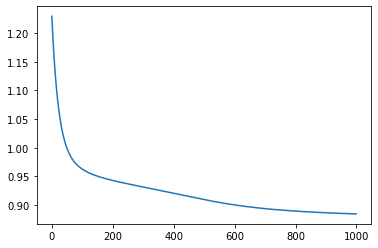

Starting training.
Training done.


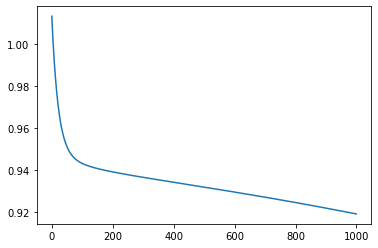

Starting training.
Training done.


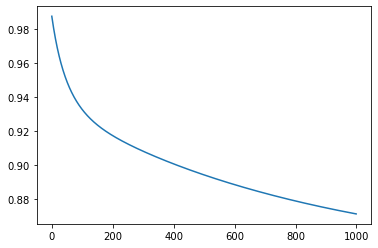

Starting training.
Training done.


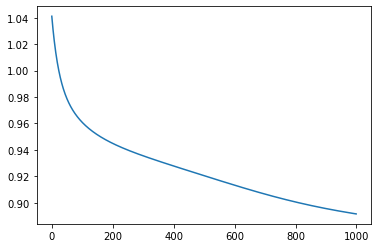

Starting training.
Training done.


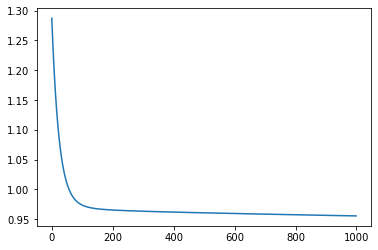

Starting training.
Training done.


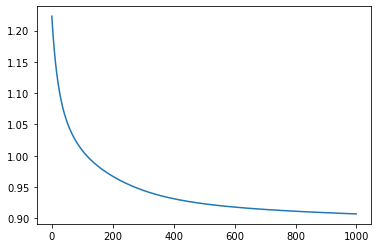

Starting training.
Training done.


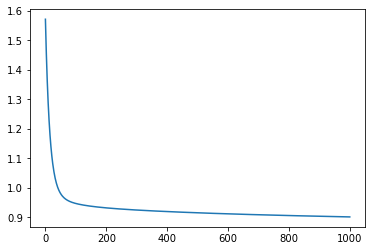

Starting training.
Training done.


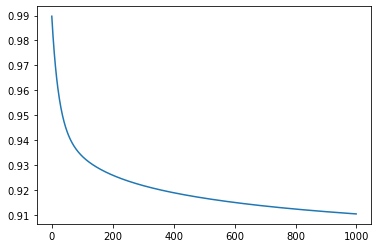

Starting training.
Training done.


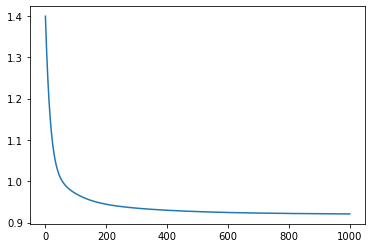

Starting training.
Training done.


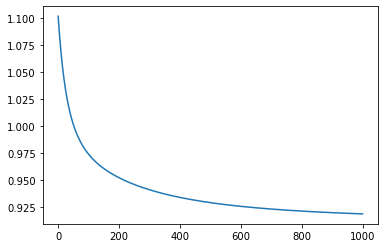

Starting training.
Training done.


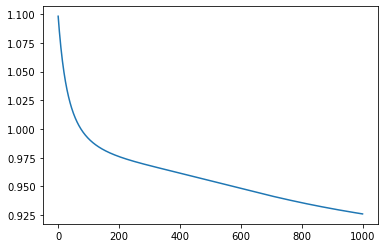

Starting training.
Training done.


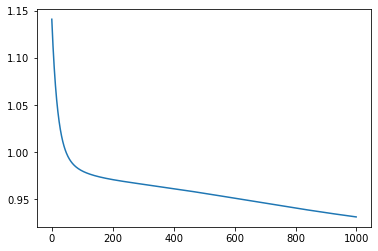

Starting training.
Training done.


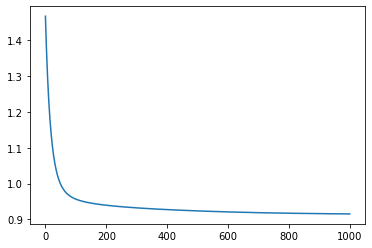

Starting training.
Training done.


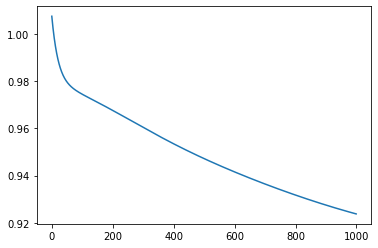

Starting training.
Training done.


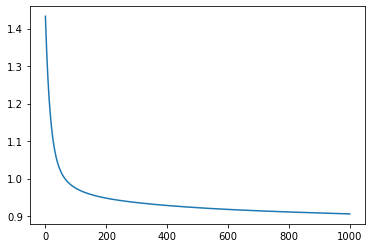

Starting training.
Training done.


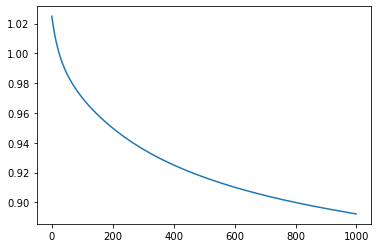

Starting training.
Training done.


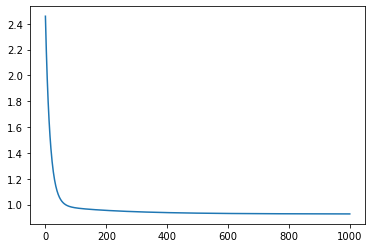

Starting training.
Training done.


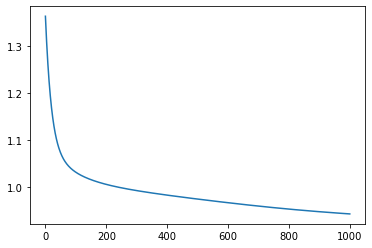

Starting training.
Training done.


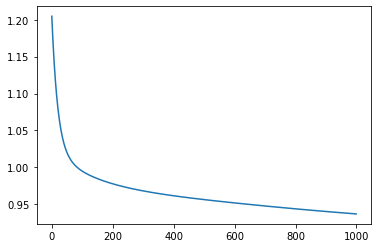

Starting training.
Training done.


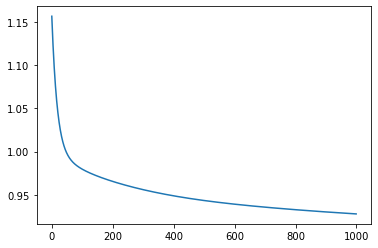

Starting training.
Training done.


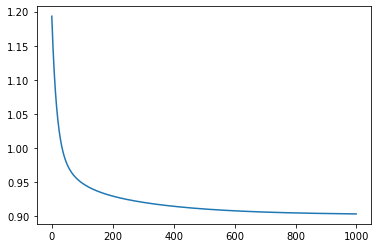

Outer fold 3 of 10
Starting training.
Training done.


C:\Users\ZHU Zheng\AppData\Local\Temp\ipykernel_22600\1666663640.py:141: RuntimeWarning: invalid value encountered in double_scalars
  p_delta_loss = np.abs(loss_value - old_loss) / old_loss


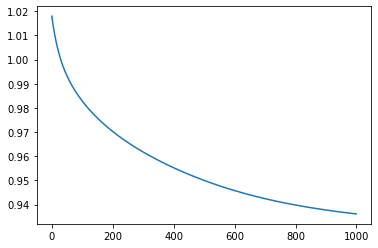

Starting training.
Training done.


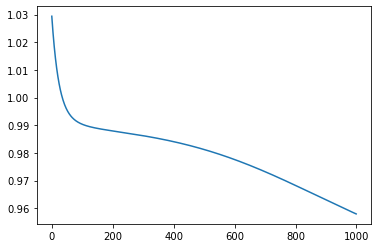

Starting training.
Training done.


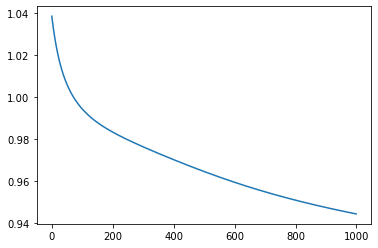

Starting training.
Training done.


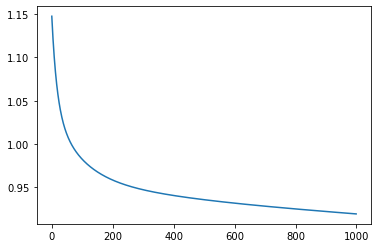

Starting training.
Training done.


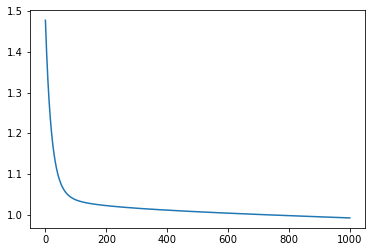

Starting training.
Training done.


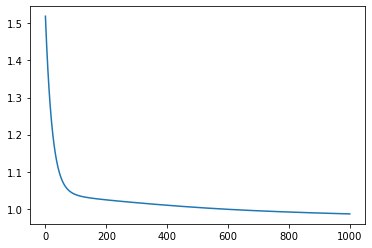

Starting training.
Training done.


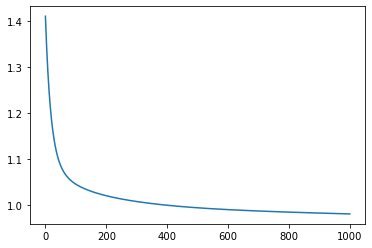

Starting training.
Training done.


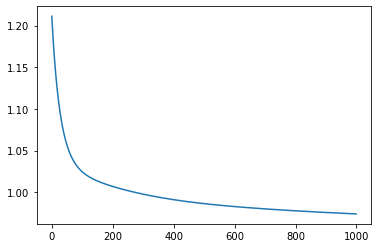

Starting training.
Training done.


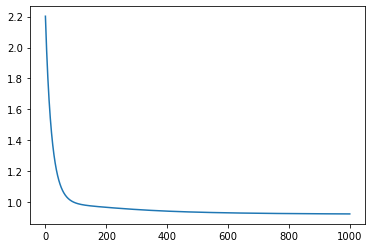

Starting training.
Training done.


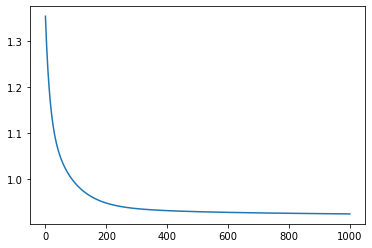

Starting training.
Training done.


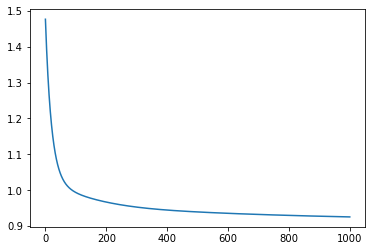

Starting training.
Training done.


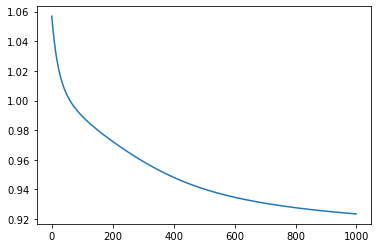

Starting training.
Training done.


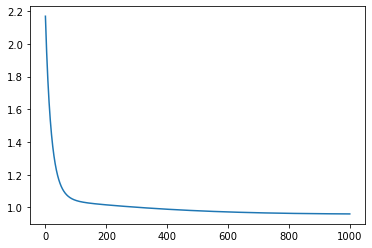

Starting training.
Training done.


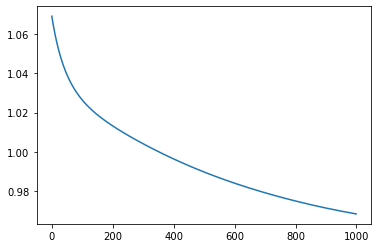

Starting training.
Training done.


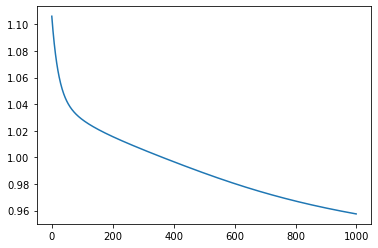

Starting training.
Training done.


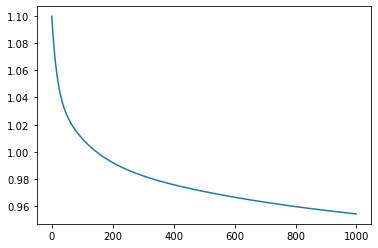

Starting training.
Training done.


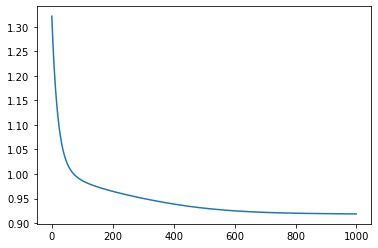

Starting training.
Training done.


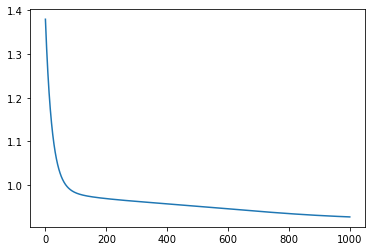

Starting training.
Training done.


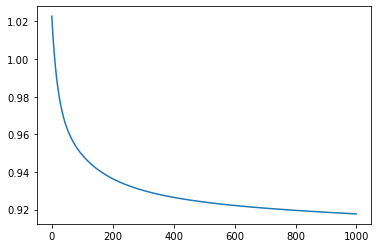

Starting training.
Training done.


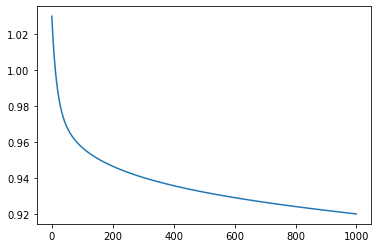

Starting training.
Training done.


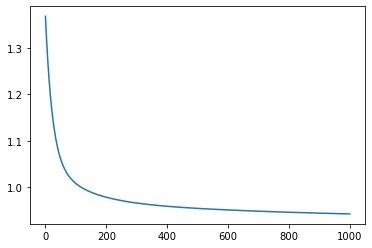

Starting training.
Training done.


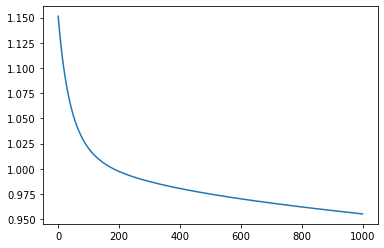

Starting training.
Training done.


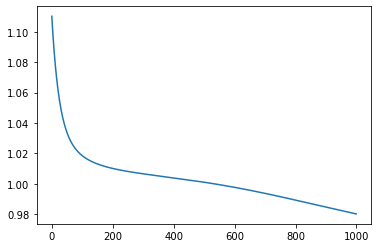

Starting training.
Training done.


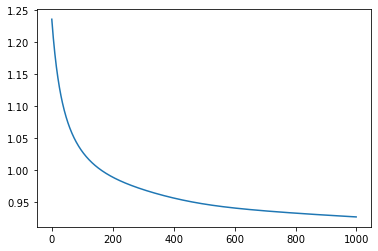

Starting training.
Training done.


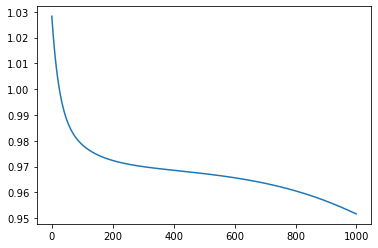

Starting training.
Training done.


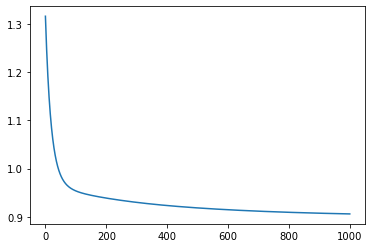

Starting training.
Training done.


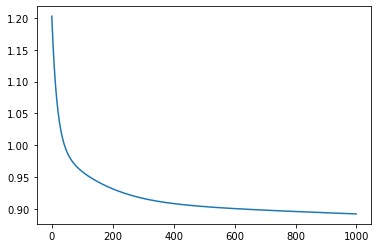

Starting training.
Training done.


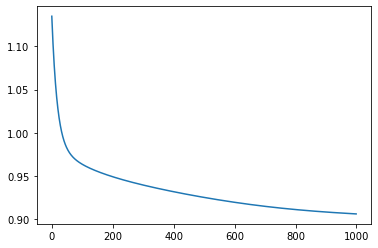

Starting training.
Training done.


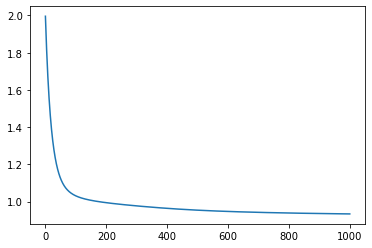

Starting training.
Training done.


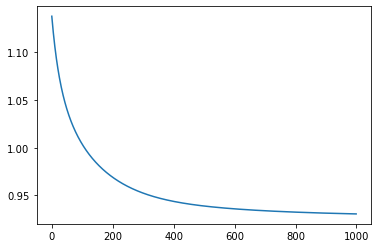

Starting training.
Training done.


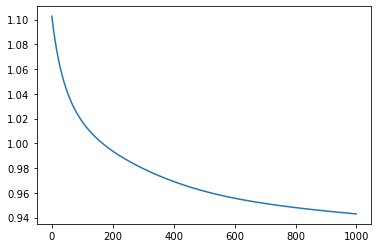

Starting training.
Training done.


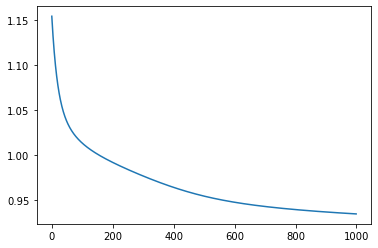

Starting training.
Training done.


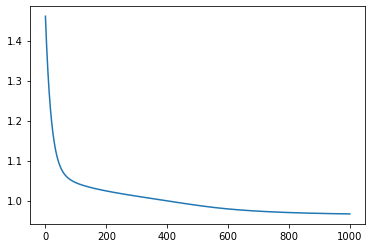

Starting training.
Training done.


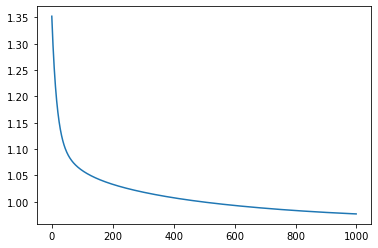

Starting training.
Training done.


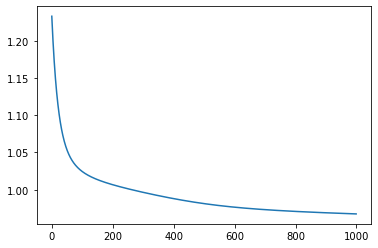

Starting training.
Training done.


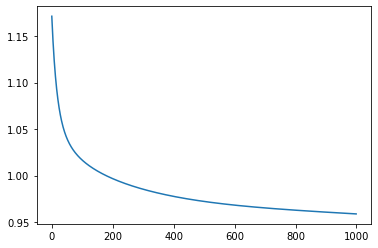

Starting training.
Training done.


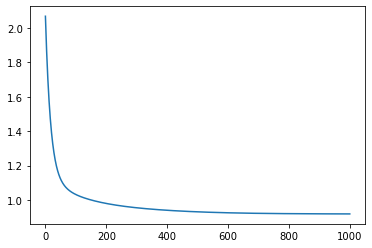

Starting training.
Training done.


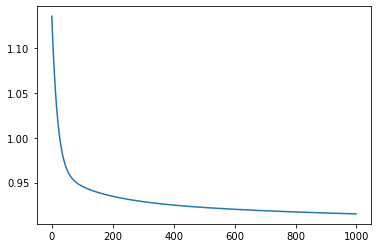

In [ ]:

import sklearn.linear_model as lm
import numpy as np

lambdas = np.power(10., range(-6, 6))
hidden_units = np.arange(1, 5)

model_types = [
  ("Linear Model", [("Linear Model, lambda = {}".format(l), l, lm.Ridge(alpha=l)) for l in lambdas]),
  ("ANN", [("ANN, h_u = {}", h_u, ANN(hidden_units = h_u)) for h_u in hidden_units]),
  ("Base Line", [("Base Line", None, BaseLine())])
]

parameter_types = ["Lambda", "Hidden units", "Nothing"] # The names of the parameters, for later convenience

def reg_error_fn(y_hat, y):
  return np.power(y - y_hat, 2).mean()

test_errors_regr, hats_regr, tests_regr = twoLayerCrossValidation(model_types, parameter_types, X_regr, y_regr, error_fn = reg_error_fn, K1=10, K2 = 10)


In [29]:
import math
import numpy as np
import torch
import torch.nn as nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as st 




# Create two Layer Cross Validation function
def twoLayerCrossValidation(model_types, parameter_types, X, y, error_fn, K1 = 10, K2 = 10):
  test_errors = np.zeros((K1,len(model_types)*2))
#  best_parameters = np.zeros((K1,len(model_types)))
  y_hat_list = []
  y_test_list = []
  for i in range(len(model_types)):
    y_hat_list.append([])

  # The two layer cross-validation algorithm
  K1fold = model_selection.KFold(n_splits=K1, shuffle = True)
  for i, (par_index, test_index) in enumerate(K1fold.split(X, y)):
    print("Outer fold {} of {}".format(i+1,K1))

    K2fold = model_selection.KFold(n_splits=K2, shuffle = True)

    # Saves D_par and D_test to allow later statistical evaluation
    X_par = X[par_index, :]
    y_par = y[par_index]

    X_test = X[test_index, :]
    y_test = y[test_index]
    y_test_list.append(y_test)
    for m, (model_type, models) in enumerate(model_types): # Iterate over the three methods chosen for classification    
      val_errors = np.zeros((K2, len(models)))

      # Inner cross validation loop
      for j, (train_index, val_index) in enumerate(K2fold.split(X_par, y_par)):
        X_train = X_par[train_index, :]
        y_train = y_par[train_index]

        X_val = X_par[val_index, :]
        y_val = y_par[val_index]

        # Test modeltype and calculate validation error for each model of the three methods
        for k, (name, parameter, model) in enumerate(models):
          model.fit(X_train, y_train)

          y_hat = model.predict(X_val)
          val_errors[j, k] = len(X_val) / len(X_par) * error_fn(y_hat, y_val)

      # Finds the optimal model
      inner_gen_errors = val_errors.sum(axis=0)
      best_model_index = np.argmin(inner_gen_errors)
      best_model_name, best_model_parameter, best_model = models[best_model_index] # Determines optimal model
      if name == 'Base Line':
        model.fit(X_par,y_par)
        y_hat = np.ones(len(y_test)) * model.predict(X_test)
        

      else:

        best_model.fit(X_par, y_par)
        y_hat = best_model.predict(X_test)
      y_hat_list[m].append(y_hat.squeeze())
      
      test_errors[i,m*2+1] = error_fn(y_hat, y_test)  # Lists test_erros for each method and each outer fold
      test_errors[i,m*2] = best_model_parameter # List the best parametertype belonging to test-error


  test_errors_folds = pd.DataFrame.from_records(data = test_errors, 
                                                columns=sum([[parameter_types[i],model_types[i][0]] for i in range(len(model_types))],[]))

  return test_errors_folds, y_hat_list, y_test_list

"""
Baseline for classification and regression
"""
# Baseline for classification
class BaseLine_Classification:
  def fit(self, X, y):
    self.bincount = np.bincount(y.astype(int)).argmax()
  
  def predict(self, X):
    return self.bincount

# Baseline for regression
class BaseLine:
  def fit(self, X, y):
    self.mean = y.mean()
  
  def predict(self, X):
    return self.mean

"""
Python class ANN for regression and CV
"""

class ANN:
  def __init__(
    self,
    hidden_units, 
    criterion = nn.MSELoss(),
    tolerance = 1e-6,
    optimizer = lambda params: torch.optim.SGD(params, lr = 1e-2),
    
  ):
    self.criterion = criterion
    self.optimizer = optimizer
    self.max_iter = 1000
    self.tolerance = tolerance
    self.hidden_units = hidden_units

  def fit(self, X, y):
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape((-1, 1))

    self.model = nn.Sequential(
      #nn.Linear(X.shape[1], y.shape[1])
      nn.Linear(X.shape[1], self.hidden_units),
      nn.Tanh(),
      nn.Linear(self.hidden_units, y.shape[1])
    )

    print("Starting training.")
    optimizer = self.optimizer(self.model.parameters())
    old_loss = math.inf
    loss_history = []
    for i in range(self.max_iter):
      optimizer.zero_grad()

      y_hat = self.model(X)
      loss = self.criterion(y_hat, y)
      loss.backward()
      loss_value = loss.item()
      loss_history.append(loss_value)

      p_delta_loss = np.abs(loss_value - old_loss) / old_loss
      if p_delta_loss < self.tolerance: break
      old_loss = loss_value
      
      optimizer.step()
    print("Training done.")
    plt.plot(loss_history)
    plt.show()
    
  def predict(self, X):
    X = torch.Tensor(X)
    y = self.model.forward(X)
    return y.detach().numpy()

def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    # perform McNemars test
    nn = np.zeros((2,2))
    c1 = yhatA - y_true == 0
    c2 = yhatB - y_true == 0

    nn[0,0] = sum(c1 & c2)
    nn[0,1] = sum(c1 & ~c2)
    nn[1,0] = sum(~c1 & c2)
    nn[1,1] = sum(~c1 & ~c2)

    n = sum(nn.flat);
    n12 = nn[0,1]
    n21 = nn[1,0]

    thetahat = (n12-n21)/n
    Etheta = thetahat

    Q = n**2 * (n+1) * (Etheta+1) * (1-Etheta) / ( (n*(n12+n21) - (n12-n21)**2) )

    p = (Etheta + 1) * (Q-1)
    q = (1-Etheta) * (Q-1)

    CI = tuple(lm * 2 - 1 for lm in st.beta.interval(1-alpha, a=p, b=q) )

    p = 2*st.binom.cdf(min([n12,n21]), n=n12+n21, p=0.5)
    # print("Result of McNemars test using alpha=", alpha)
    # print("Comparison matrix n")
    # print(nn)
    if n12+n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=",(n12+n21))

    # print("Approximate {} confidence interval of theta: [thetaL,thetaU] = ".format(1-alpha), CI)
    # print("p-value for two-sided test A and B have same accuracy (exact binomial test): p=", p)

    # thetahat = 2*thetahat-1
    return thetahat, CI, p

In [30]:


import numpy as np


from sklearn import model_selection, tree
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
import sklearn.linear_model as lm
from sklearn.linear_model import LogisticRegression


"""
  Below is a list of the methods used for classification.
  For each method models with different complexity parameter is chosen.
  2-Layer cross validation is used to estimate the generalization error of the
  model. The inner loop choses the optimal complexity parameter, the outer 
  calculates the test error for that optimal model on the rest of the data set
"""
lambdas = lambdas = np.arange(0.1,50,0.1) # lige ændret fra (0,20,0.1)
model_types = [
  ("Logistic Regression", [
    ("Logistic Lambda = {}".format(l),l, lm.LogisticRegression(solver='liblinear', C = 1/l ))
    for l in lambdas
  ]),
  ("Nearest Neighbour", [
    ("{}NN".format(k),k, KNeighborsClassifier(n_neighbors=k)) 
      for k in np.arange(1, 20)
  ]),
  ("Base Line", [("Base Line", None, BaseLine_Classification())])

]
  # Add baseline model

parameter_types = ["Lambda_vals","Number of neighbours", "None"] # The names of the parameters, for later convenience

def class_error_fn(y_hat, y):
  return (y_hat != y).mean()

test_errors, hats, tests = twoLayerCrossValidation(model_types, parameter_types, X, y, error_fn = class_error_fn)

Outer fold 1 of 10
Outer fold 2 of 10
Outer fold 3 of 10
Outer fold 4 of 10
Outer fold 5 of 10
Outer fold 6 of 10
Outer fold 7 of 10
Outer fold 8 of 10
Outer fold 9 of 10
Outer fold 10 of 10


In [31]:
import math
import numpy as np
import torch
import torch.nn as nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as st 




# Create two Layer Cross Validation function
def twoLayerCrossValidation(model_types, parameter_types, X, y, error_fn, K1 = 10, K2 = 10):
  test_errors = np.zeros((K1,len(model_types)*2))
#  best_parameters = np.zeros((K1,len(model_types)))
  y_hat_list = []
  y_test_list = []
  for i in range(len(model_types)):
    y_hat_list.append([])

  # The two layer cross-validation algorithm
  K1fold = model_selection.KFold(n_splits=K1, shuffle = True)
  for i, (par_index, test_index) in enumerate(K1fold.split(X, y)):
    print("Outer fold {} of {}".format(i+1,K1))

    K2fold = model_selection.KFold(n_splits=K2, shuffle = True)

    # Saves D_par and D_test to allow later statistical evaluation
    X_par = X[par_index, :]
    y_par = y[par_index]

    X_test = X[test_index, :]
    y_test = y[test_index]
    y_test_list.append(y_test)
    for m, (model_type, models) in enumerate(model_types): # Iterate over the three methods chosen for classification    
      val_errors = np.zeros((K2, len(models)))

      # Inner cross validation loop
      for j, (train_index, val_index) in enumerate(K2fold.split(X_par, y_par)):
        X_train = X_par[train_index, :]
        y_train = y_par[train_index]

        X_val = X_par[val_index, :]
        y_val = y_par[val_index]

        # Test modeltype and calculate validation error for each model of the three methods
        for k, (name, parameter, model) in enumerate(models):
          model.fit(X_train, y_train)

          y_hat = model.predict(X_val)
          val_errors[j, k] = len(X_val) / len(X_par) * error_fn(y_hat, y_val)

      # Finds the optimal model
      inner_gen_errors = val_errors.sum(axis=0)
      best_model_index = np.argmin(inner_gen_errors)
      best_model_name, best_model_parameter, best_model = models[best_model_index] # Determines optimal model
      if name == 'Base Line':
        model.fit(X_par,y_par)
        y_hat = np.ones(len(y_test)) * model.predict(X_test)
        

      else:

        best_model.fit(X_par, y_par)
        y_hat = best_model.predict(X_test)
      y_hat_list[m].append(y_hat.squeeze())
      
      test_errors[i,m*2+1] = error_fn(y_hat, y_test)  # Lists test_erros for each method and each outer fold
      test_errors[i,m*2] = best_model_parameter # List the best parametertype belonging to test-error


  test_errors_folds = pd.DataFrame.from_records(data = test_errors, 
                                                columns=sum([[parameter_types[i],model_types[i][0]] for i in range(len(model_types))],[]))

  return test_errors_folds, y_hat_list, y_test_list

"""
Baseline for classification and regression
"""
# Baseline for classification
class BaseLine_Classification:
  def fit(self, X, y):
    self.bincount = np.bincount(y.astype(int)).argmax()
  
  def predict(self, X):
    return self.bincount

# Baseline for regression
class BaseLine:
  def fit(self, X, y):
    self.mean = y.mean()
  
  def predict(self, X):
    return self.mean

"""
Python class ANN for regression and CV
"""

class ANN:
  def __init__(
    self,
    hidden_units, 
    criterion = nn.MSELoss(),
    tolerance = 1e-6,
    optimizer = lambda params: torch.optim.SGD(params, lr = 1e-2),
    
  ):
    self.criterion = criterion
    self.optimizer = optimizer
    self.max_iter = 1000
    self.tolerance = tolerance
    self.hidden_units = hidden_units

  def fit(self, X, y):
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape((-1, 1))

    self.model = nn.Sequential(
      #nn.Linear(X.shape[1], y.shape[1])
      nn.Linear(X.shape[1], self.hidden_units),
      nn.Tanh(),
      nn.Linear(self.hidden_units, y.shape[1])
    )

    print("Starting training.")
    optimizer = self.optimizer(self.model.parameters())
    old_loss = math.inf
    loss_history = []
    for i in range(self.max_iter):
      optimizer.zero_grad()

      y_hat = self.model(X)
      loss = self.criterion(y_hat, y)
      loss.backward()
      loss_value = loss.item()
      loss_history.append(loss_value)

      p_delta_loss = np.abs(loss_value - old_loss) / old_loss
      if p_delta_loss < self.tolerance: break
      old_loss = loss_value
      
      optimizer.step()
    print("Training done.")
    plt.plot(loss_history)
    plt.show()
    
  def predict(self, X):
    X = torch.Tensor(X)
    y = self.model.forward(X)
    return y.detach().numpy()

def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    # perform McNemars test
    nn = np.zeros((2,2))
    c1 = yhatA - y_true == 0
    c2 = yhatB - y_true == 0

    nn[0,0] = sum(c1 & c2)
    nn[0,1] = sum(c1 & ~c2)
    nn[1,0] = sum(~c1 & c2)
    nn[1,1] = sum(~c1 & ~c2)

    n = sum(nn.flat);
    n12 = nn[0,1]
    n21 = nn[1,0]

    thetahat = (n12-n21)/n
    Etheta = thetahat

    Q = n**2 * (n+1) * (Etheta+1) * (1-Etheta) / ( (n*(n12+n21) - (n12-n21)**2) )

    p = (Etheta + 1) * (Q-1)
    q = (1-Etheta) * (Q-1)

    CI = tuple(lm * 2 - 1 for lm in st.beta.interval(1-alpha, a=p, b=q) )

    p = 2*st.binom.cdf(min([n12,n21]), n=n12+n21, p=0.5)
    # print("Result of McNemars test using alpha=", alpha)
    # print("Comparison matrix n")
    # print(nn)
    if n12+n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=",(n12+n21))

    # print("Approximate {} confidence interval of theta: [thetaL,thetaU] = ".format(1-alpha), CI)
    # print("p-value for two-sided test A and B have same accuracy (exact binomial test): p=", p)

    # thetahat = 2*thetahat-1
    return thetahat, CI, p

In [23]:

import numpy as np


print(test_errors)
predicted_log = np.concatenate(hats[0])
predicted_KNN = np.concatenate(hats[1])
predicted_BL = np.concatenate(hats[2])
true_class = np.concatenate(tests)
alpha = 0.05


z_1, CI_log_vs_KNN, p_log_vs_KNN = mcnemar(true_class, predicted_log, predicted_KNN, alpha = 0.05)
z_2, CI_log_vs_BL, p_log_vs_BL = mcnemar(true_class, predicted_log, predicted_BL, alpha = 0.05)
z_3, CI_KNN_vs_BL, p_KNN_vs_BL = mcnemar(true_class, predicted_KNN, predicted_BL, alpha = 0.05)

print("P_value for the null hypothesis: Log = KNN: ",p_log_vs_KNN)
print(1-alpha, "% Confidence interval for difference in accuracy between log and KNN: ", CI_log_vs_KNN)
print("")
print("P_value for the null hypothesis: Log = BL: ",p_log_vs_BL)
print(1-alpha, "% Confidence interval for difference in accuracy between log and BL: ", CI_log_vs_BL)
print("")
print("P_value for the null hypothesis: KNN = BL: ",p_KNN_vs_BL)
print(1-alpha, "% Confidence interval for difference in accuracy between KNN and BL ", CI_KNN_vs_BL)

print("Test_statistic, theta1: ",z_1)
print("Test_statistic, theta2: ",z_2)
print("Test_statistic, theta3: ",z_3)

print(("Mean Accuracy log: ", ((predicted_log == true_class)*1).mean()))
print(("Mean Accuracy KNN: ",((predicted_KNN == true_class)*1).mean()))
print(("Mean Accuracy BL: ", ((predicted_BL == true_class)*1).mean()))


   Lambda_vals  Logistic Regression  Number of neighbours  Nearest Neighbour  \
0          3.6             0.276596                  13.0           0.404255   
1          5.2             0.276596                  19.0           0.255319   
2          3.6             0.282609                  11.0           0.326087   
3         45.5             0.260870                  13.0           0.260870   
4          0.1             0.282609                  13.0           0.239130   
5          8.1             0.326087                  12.0           0.304348   
6          5.4             0.369565                  11.0           0.347826   
7         26.3             0.369565                  13.0           0.347826   
8          0.2             0.369565                  19.0           0.369565   
9          2.4             0.239130                  11.0           0.369565   

   None  Base Line  
0   NaN   0.425532  
1   NaN   0.319149  
2   NaN   0.282609  
3   NaN   0.391304  
4   NaN   0.17